In [1]:
import sys
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import tqdm
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from calculate_probabilities import calc_probs_for_single_tcr, calc_probs_for_every_tcr
from pdf import generate_configuration_per_tcr, ci_pdf, plot_pdf
from concurrent.futures import ProcessPoolExecutor

ModuleNotFoundError: No module named 'numba'

100%|██████████| 21556/21556 [16:29<00:00, 21.78it/s]


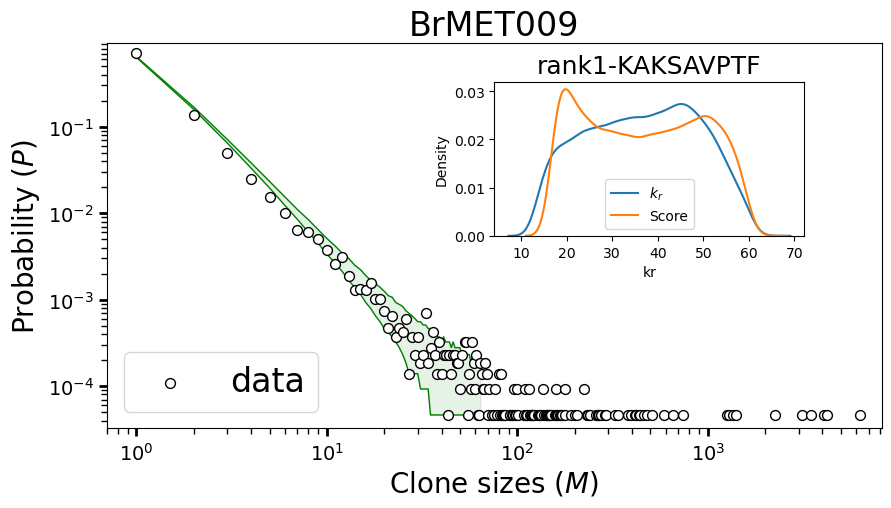

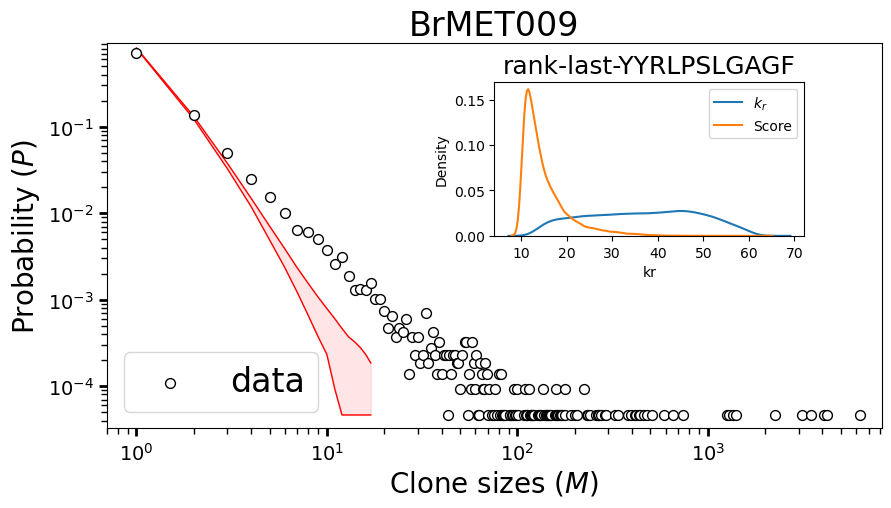

In [10]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_csv(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/parameters.csv",
        sep=",",
    )
patient_id = 'BrMET009'
patient_data = full_data[full_data["Patient"]==patient_id]
clone_count_values = patient_data['counts']
n = len(clone_count_values)
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
neoantigens = region_level_data['Peptide'].unique()
num_of_neoantigens = len(neoantigens)
ks_stats = [ks_2samp(region_level_data[region_level_data['Peptide']==peptide]['Score'].values*num_of_neoantigens, patient_data['kr']).statistic for peptide in neoantigens]
best_neoantigen = neoantigens[np.argmin(ks_stats)]
worst_neoantigen = neoantigens[np.argmax(ks_stats)]
best_neoantigen_data = region_level_data[region_level_data['Peptide']==best_neoantigen]
worst_neoantigen_data = region_level_data[region_level_data['Peptide']==worst_neoantigen]
patient_params_df = params_df[params_df["Patient"] == patient_id]
x1_value = patient_params_df["x1"].values[0]
x2_value = patient_params_df["x2"].values[0]
maxM = 10000
probs_for_best_neoantigen = calc_probs_for_every_TCR(best_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
probs_for_worst_neoantigen = calc_probs_for_every_TCR(worst_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
size = 1000
least_number_of_observations = 10
fig1, ax1 = plot_pdf(clone_count_values)
configs_from_best_neoantigen = generate_configuration_per_tcr(probs_for_best_neoantigen, size=size)
ci_df = ci_pdf(configs_from_best_neoantigen, least_number_of_observations=least_number_of_observations)
ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
ax1.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1)#, label=f'rank1-{best_neoantigen}')
ax1.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
ax1.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)

fig2, ax2 = plot_pdf(clone_count_values)
configs_from_worst_neoantigen = generate_configuration_per_tcr(probs_for_worst_neoantigen, size=size)
ci_df = ci_pdf(configs_from_worst_neoantigen, least_number_of_observations=least_number_of_observations)
ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
ax2.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='red', alpha=0.1, zorder=1)#, label=f'rank-last-{worst_neoantigen}')
ax2.plot(ci_df['clone_size'], ci_df['lower'], color='red', alpha=1., linewidth=1., zorder=1)
ax2.plot(ci_df['clone_size'], ci_df['upper'], color='red', alpha=1., linewidth=1., zorder=1)

axes = [ax1, ax2]
for ax in axes:
    # Plot KDE inset
    inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
    sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
    if ax == ax1:
        sns.kdeplot(best_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
        inset_ax.set_title(f'rank1-{best_neoantigen}', fontsize=18)
    else:
        sns.kdeplot(worst_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
        inset_ax.set_title(f'rank-last-{worst_neoantigen}', fontsize=18)
    inset_ax.legend()
    
    # Set main plot properties
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='lower left', fontsize=24)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)

plt.show()

100%|██████████| 13606/13606 [10:22<00:00, 21.85it/s]


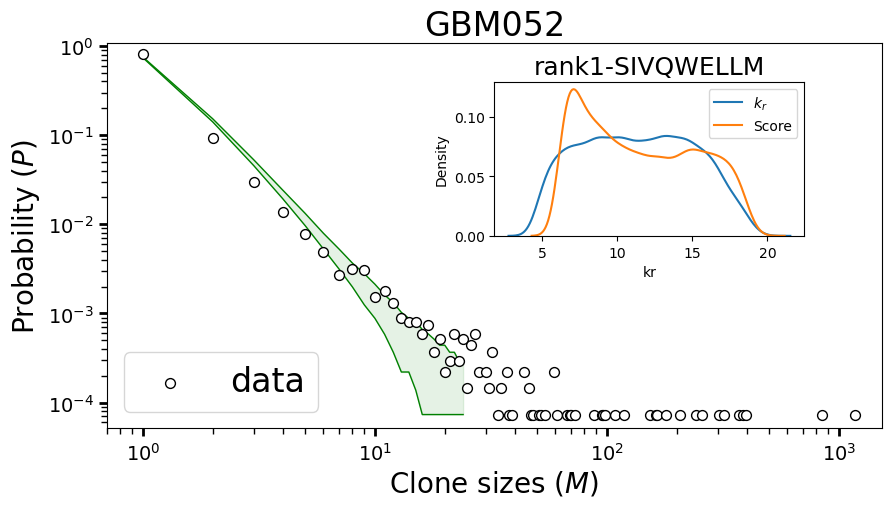

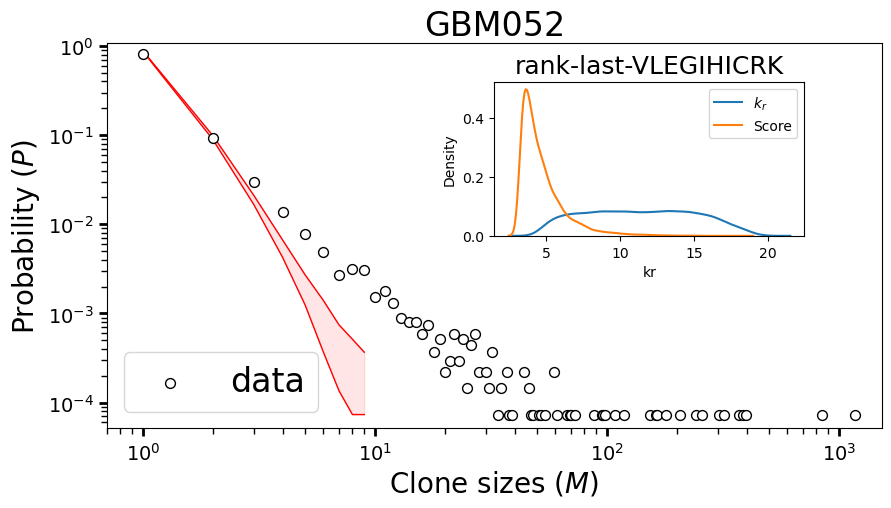

In [11]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_csv(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/parameters.csv",
        sep=",",
    )
patient_id = 'GBM052'
patient_data = full_data[full_data["Patient"]==patient_id]
clone_count_values = patient_data['counts']
n = len(clone_count_values)
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
neoantigens = region_level_data['Peptide'].unique()
num_of_neoantigens = len(neoantigens)
ks_stats = [ks_2samp(region_level_data[region_level_data['Peptide']==peptide]['Score'].values*num_of_neoantigens, patient_data['kr']).statistic for peptide in neoantigens]
best_neoantigen = neoantigens[np.argmin(ks_stats)]
worst_neoantigen = neoantigens[np.argmax(ks_stats)]
best_neoantigen_data = region_level_data[region_level_data['Peptide']==best_neoantigen]
worst_neoantigen_data = region_level_data[region_level_data['Peptide']==worst_neoantigen]
patient_params_df = params_df[params_df["Patient"] == patient_id]
x1_value = patient_params_df["x1"].values[0]
x2_value = patient_params_df["x2"].values[0]
maxM = 10000
probs_for_best_neoantigen = calc_probs_for_every_TCR(best_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
probs_for_worst_neoantigen = calc_probs_for_every_TCR(worst_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
size = 1000
least_number_of_observations = 10
fig1, ax1 = plot_pdf(clone_count_values)
configs_from_best_neoantigen = generate_configuration_per_tcr(probs_for_best_neoantigen, size=size)
ci_df = ci_pdf(configs_from_best_neoantigen, least_number_of_observations=least_number_of_observations)
ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
ax1.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1)#, label=f'rank1-{best_neoantigen}')
ax1.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
ax1.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)

fig2, ax2 = plot_pdf(clone_count_values)
configs_from_worst_neoantigen = generate_configuration_per_tcr(probs_for_worst_neoantigen, size=size)
ci_df = ci_pdf(configs_from_worst_neoantigen, least_number_of_observations=least_number_of_observations)
ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
ax2.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='red', alpha=0.1, zorder=1)#, label=f'rank-last-{worst_neoantigen}')
ax2.plot(ci_df['clone_size'], ci_df['lower'], color='red', alpha=1., linewidth=1., zorder=1)
ax2.plot(ci_df['clone_size'], ci_df['upper'], color='red', alpha=1., linewidth=1., zorder=1)

axes = [ax1, ax2]
for ax in axes:
    # Plot KDE inset
    inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
    sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
    if ax == ax1:
        sns.kdeplot(best_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
        inset_ax.set_title(f'rank1-{best_neoantigen}', fontsize=18)
    else:
        sns.kdeplot(worst_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
        inset_ax.set_title(f'rank-last-{worst_neoantigen}', fontsize=18)
    inset_ax.legend()
    
    # Set main plot properties
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='lower left', fontsize=24)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)

plt.show()

In [9]:
import scipy.stats
def candidate_distributions(data, topn: float = 0.1):
    if isinstance(data, pd.DataFrame):
        means = data.mean(axis=0).values
        skewnesses = data.skew(axis=0).values
    elif isinstance(data, np.ndarray):
        means = data.mean(axis=0)
        skewnesses = scipy.stats.skew(data, axis=0)
    else:
        raise ValueError("Data should be either a pandas DataFrame or a numpy array")

    # print("Means:", means)
    # print("Skewnesses:", skewnesses)

    best_indices = np.argsort(means)[::-1]  # Sort indices by mean in descending order

    best_distributions = [
        (i, means[i], skewnesses[i]) for i in best_indices if skewnesses[i] < 0
    ]

    topn_distributions = best_distributions[: int(len(best_distributions) * topn)]
    # print(
    #     f"Best {int(topn*100)}% distributions (Item, Mean, Skewness):",
    #     topn_distributions,
    # )
    print(f"Top {int(len(best_distributions) * topn)}/{data.shape[1]} were chosen.")
    return topn_distributions

Top 3/80 were chosen.


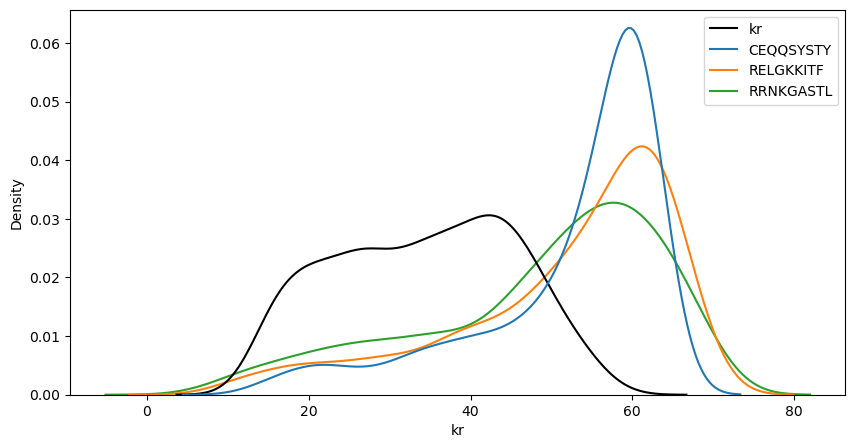

100%|██████████| 863/863 [00:06<00:00, 143.31it/s]


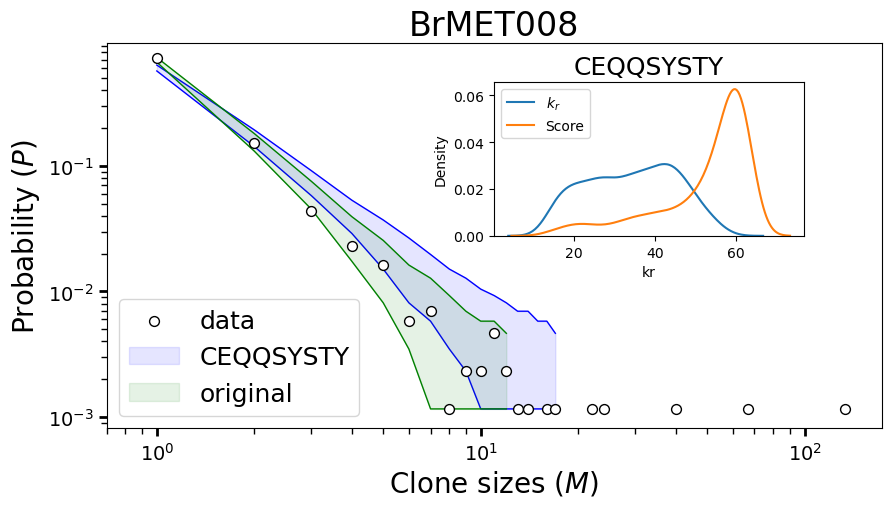

In [10]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_csv(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/parameters.csv",
        sep=",",
    )
patient_id = 'BrMET008'
patient_data = full_data[full_data["Patient"]==patient_id]
clone_count_values = patient_data['counts']
n = len(clone_count_values)
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
neoantigens = region_level_data['Peptide'].unique()
num_of_neoantigens = len(neoantigens)
score_array = np.empty((n, num_of_neoantigens))
for i, peptide in enumerate(neoantigens[:]):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    score_array[:, i] = req_df['Score'].values*num_of_neoantigens
candidate_stats = candidate_distributions(score_array, topn=0.1)
candidate_peptides = [neoantigens[stat[0]] for stat in candidate_stats]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.kdeplot(patient_data['kr'], ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    sns.kdeplot(req_df['Score']*num_of_neoantigens, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
plt.show()

#################################################################
patient_params_df = params_df[params_df["Patient"] == patient_id]
x1_value = patient_params_df["x1"].values[0]
x2_value = patient_params_df["x2"].values[0]
maxM = 1000
for peptide in candidate_peptides[:1]:
    req_data = region_level_data[region_level_data['Peptide']==peptide]
    probs_ = calc_probs_for_every_TCR(req_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
    size = 1000
    least_number_of_observations = 10
    fig, ax = plot_pdf(clone_count_values)
    configs_from_best_candidate = generate_configuration_per_tcr(probs_, size=size)
    ci_df = ci_pdf(configs_from_best_candidate, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='blue', alpha=0.1, zorder=1, label=f'{peptide}')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='blue', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='blue', alpha=1., linewidth=1., zorder=1)

    # Plot KDE inset
    inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
    sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
    sns.kdeplot(req_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
    inset_ax.set_title(f'{peptide}', fontsize=18)
    inset_ax.legend()
    
    ######################### original ##########################
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
    all_configs = generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1, label='original')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)
    ###########################################################################
    
    # Set main plot properties
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='lower left', fontsize=18)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)    

    plt.show()

Top 4/82 were chosen.


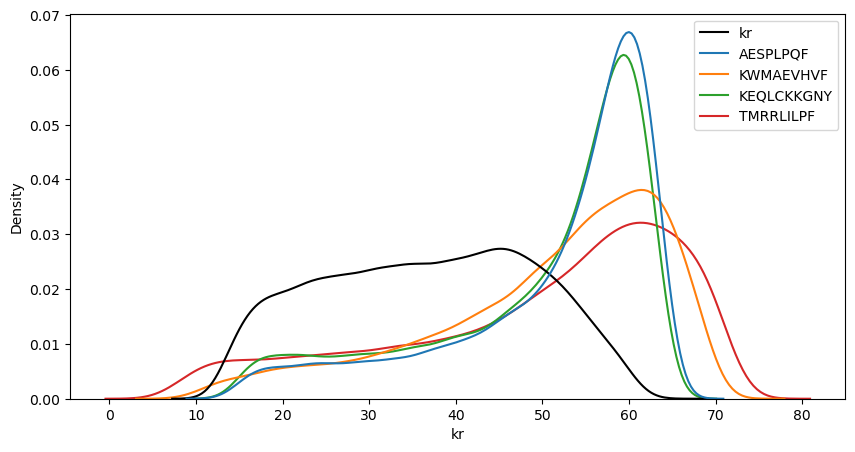

100%|██████████| 21556/21556 [19:30<00:00, 18.41it/s]


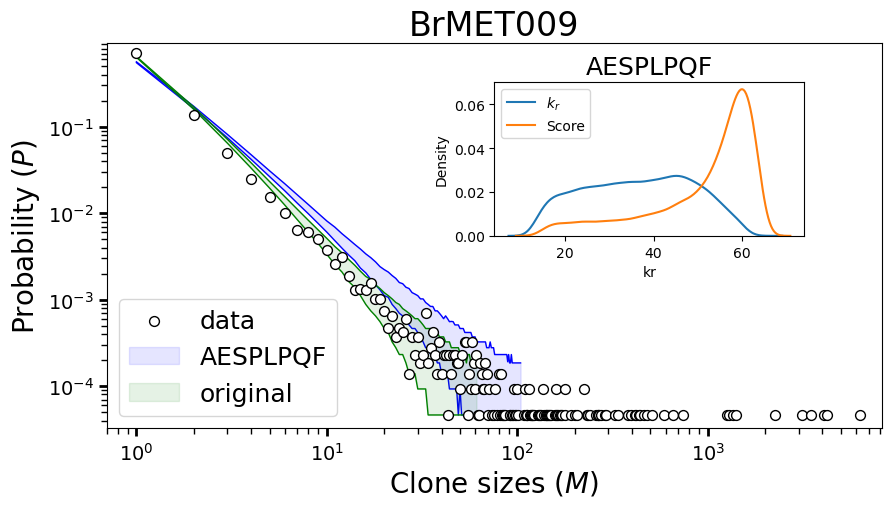

In [13]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_csv(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/parameters.csv",
        sep=",",
    )
patient_id = 'BrMET009'
patient_data = full_data[full_data["Patient"]==patient_id]
clone_count_values = patient_data['counts']
n = len(clone_count_values)
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
neoantigens = region_level_data['Peptide'].unique()
num_of_neoantigens = len(neoantigens)
score_array = np.empty((n, num_of_neoantigens))
for i, peptide in enumerate(neoantigens[:]):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    score_array[:, i] = req_df['Score'].values*num_of_neoantigens
candidate_stats = candidate_distributions(score_array, topn=0.1)
candidate_peptides = [neoantigens[stat[0]] for stat in candidate_stats]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.kdeplot(patient_data['kr'], ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    sns.kdeplot(req_df['Score']*num_of_neoantigens, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
ax.set_title(f'{patient_id}', fontsize=24)
plt.show()

#################################################################
patient_params_df = params_df[params_df["Patient"] == patient_id]
x1_value = patient_params_df["x1"].values[0]
x2_value = patient_params_df["x2"].values[0]
maxM = 10000
for peptide in candidate_peptides[:1]:
    req_data = region_level_data[region_level_data['Peptide']==peptide]
    probs_ = calc_probs_for_every_TCR(req_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
    size = 1000
    least_number_of_observations = 10
    fig, ax = plot_pdf(clone_count_values)
    configs_from_best_candidate = generate_configuration_per_tcr(probs_, size=size)
    ci_df = ci_pdf(configs_from_best_candidate, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='blue', alpha=0.1, zorder=1, label=f'{peptide}')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='blue', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='blue', alpha=1., linewidth=1., zorder=1)

    # Plot KDE inset
    inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
    sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
    sns.kdeplot(req_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
    inset_ax.set_title(f'{peptide}', fontsize=18)
    inset_ax.legend()
    
    ######################### original ##########################
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
    all_configs = generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1, label='original')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)
    ###########################################################################
    
    # Set main plot properties
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='lower left', fontsize=18)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)    

    plt.show()

Top 4/27 were chosen.


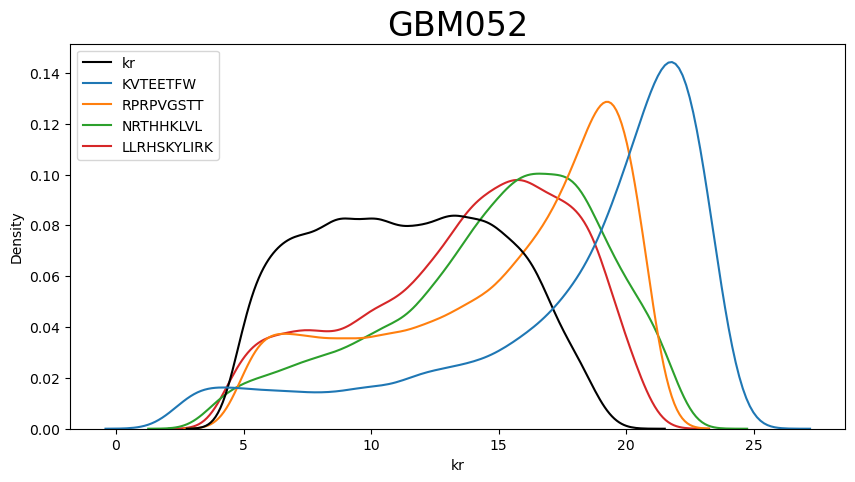

100%|██████████| 13606/13606 [12:05<00:00, 18.75it/s]


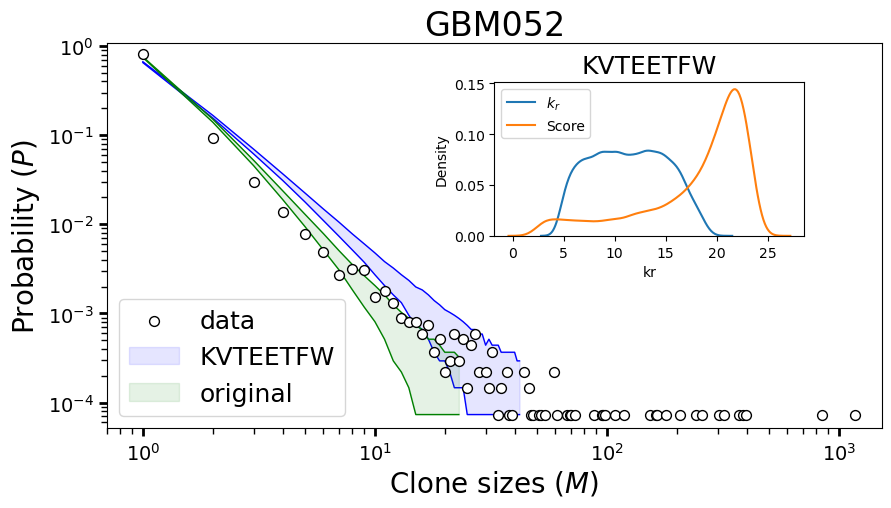

In [17]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_csv(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/parameters.csv",
        sep=",",
    )
patient_id = 'GBM052'
patient_data = full_data[full_data["Patient"]==patient_id]
clone_count_values = patient_data['counts']
n = len(clone_count_values)
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
neoantigens = region_level_data['Peptide'].unique()
num_of_neoantigens = len(neoantigens)
score_array = np.empty((n, num_of_neoantigens))
for i, peptide in enumerate(neoantigens[:]):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    score_array[:, i] = req_df['Score'].values*num_of_neoantigens
candidate_stats = candidate_distributions(score_array, topn=0.5)
candidate_peptides = [neoantigens[stat[0]] for stat in candidate_stats]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.kdeplot(patient_data['kr'], ax=ax, color='black', linewidth=1.5, zorder=0, label='kr')
for i, peptide in enumerate(candidate_peptides):
    req_df = region_level_data[region_level_data['Peptide']==peptide]
    sns.kdeplot(req_df['Score']*num_of_neoantigens, ax=ax, zorder=-1*i, label=f'{peptide}')
ax.legend(loc='best')
ax.set_title(f'{patient_id}', fontsize=24)
plt.show()

#################################################################
patient_params_df = params_df[params_df["Patient"] == patient_id]
x1_value = patient_params_df["x1"].values[0]
x2_value = patient_params_df["x2"].values[0]
maxM = 10000
for peptide in candidate_peptides[:1]:
    req_data = region_level_data[region_level_data['Peptide']==peptide]
    probs_ = calc_probs_for_every_TCR(req_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
    size = 1000
    least_number_of_observations = 10
    fig, ax = plot_pdf(clone_count_values)
    configs_from_best_candidate = generate_configuration_per_tcr(probs_, size=size)
    ci_df = ci_pdf(configs_from_best_candidate, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='blue', alpha=0.1, zorder=1, label=f'{peptide}')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='blue', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='blue', alpha=1., linewidth=1., zorder=1)

    # Plot KDE inset
    inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
    sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
    sns.kdeplot(req_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
    inset_ax.set_title(f'{peptide}', fontsize=18)
    inset_ax.legend()
    
    ######################### original ##########################
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
    all_configs = generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1, label='original')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)
    ###########################################################################
    
    # Set main plot properties
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='lower left', fontsize=18)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)    

    plt.show()

### TESTING ON INDIVIDUAL REGIONS

100 2.855181010571006


Processing TCRs: 100%|██████████| 770/770 [00:16<00:00, 45.49it/s]


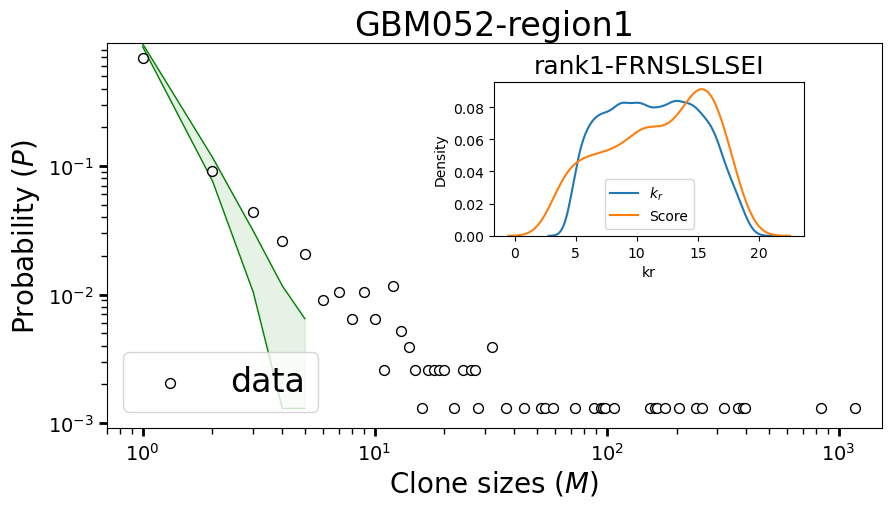

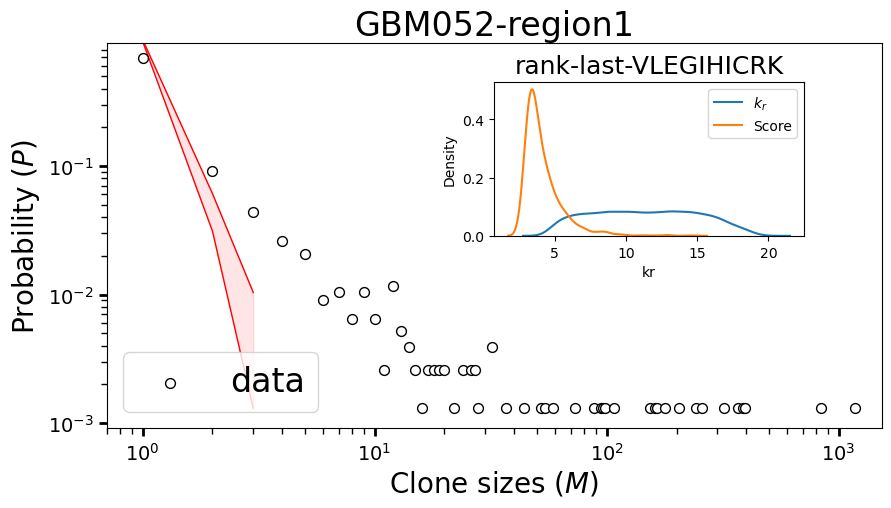

In [8]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_excel(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx",
        engine='openpyxl',
    )
patient_id = 'GBM052'
patient_data = full_data[full_data['Patient']==patient_id]
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
regions = [region for region in region_level_data.columns if 'region' in region]
for region in regions[:1]:
    req_df = region_level_data[region_level_data[region]=='Yes']
    req_df = req_df.merge(patient_data, on='CDR3', how='inner')[list(req_df.columns)+['counts']]
    neoantigens = req_df['Peptide'].unique()
    num_of_neoantigens = len(neoantigens)
    ks_stats = [ks_2samp(req_df[req_df['Peptide']==peptide]['Score'].values*num_of_neoantigens, patient_data['kr']).statistic for peptide in neoantigens]
    best_neoantigen = neoantigens[np.argmin(ks_stats)]
    worst_neoantigen = neoantigens[np.argmax(ks_stats)]
    # print(f'{region}', best_neoantigen, worst_neoantigen)
    best_neoantigen_data = req_df[req_df['Peptide']==best_neoantigen]
    worst_neoantigen_data = req_df[req_df['Peptide']==worst_neoantigen]
    patient_params_df = params_df[(params_df["Patient"] == patient_id) & (params_df["Region"] == region)]
    x1_value = patient_params_df["x1_panpep"].values[0]
    x2_value = patient_params_df["x2_panpep"].values[0]
    print(x1_value, x2_value)
    maxM = 10000
    probs_for_best_neoantigen = calc_probs_for_every_tcr(best_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
    probs_for_worst_neoantigen = calc_probs_for_every_tcr(worst_neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM)
    size = 1000
    least_number_of_observations = 10
    
    clone_count_values = req_df['counts']
    fig1, ax1 = plot_pdf(clone_count_values)
    configs_from_best_neoantigen = generate_configuration_per_tcr(probs_for_best_neoantigen, size=size)
    ci_df = ci_pdf(configs_from_best_neoantigen, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax1.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1)#, label=f'rank1-{best_neoantigen}')
    ax1.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
    ax1.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)

    fig2, ax2 = plot_pdf(clone_count_values)
    configs_from_worst_neoantigen = generate_configuration_per_tcr(probs_for_worst_neoantigen, size=size)
    ci_df = ci_pdf(configs_from_worst_neoantigen, least_number_of_observations=least_number_of_observations)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median']) &  (ci_df['median']!=ci_df['upper'])]
    ax2.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='red', alpha=0.1, zorder=1)#, label=f'rank-last-{worst_neoantigen}')
    ax2.plot(ci_df['clone_size'], ci_df['lower'], color='red', alpha=1., linewidth=1., zorder=1)
    ax2.plot(ci_df['clone_size'], ci_df['upper'], color='red', alpha=1., linewidth=1., zorder=1)

    axes = [ax1, ax2]
    for ax in axes:
        # Plot KDE inset
        inset_ax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])
        sns.kdeplot(patient_data['kr'], ax=inset_ax, label=r'$k_r$')
        if ax == ax1:
            sns.kdeplot(best_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
            inset_ax.set_title(f'rank1-{best_neoantigen}', fontsize=18)
        else:
            sns.kdeplot(worst_neoantigen_data['Score']*num_of_neoantigens, ax=inset_ax, label=f'Score')
            inset_ax.set_title(f'rank-last-{worst_neoantigen}', fontsize=18)
        inset_ax.legend()
        
        # Set main plot properties
        ax.set_title(f'{patient_id}-{region}', fontsize=24)
        ax.legend(loc='lower left', fontsize=24)
        ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
        ax.set_ylabel('Probability ($P$)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
        ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)

    plt.show()

Processing BrMET008-region4:: 100%|██████████| 76/76 [09:26<00:00,  7.45s/it]


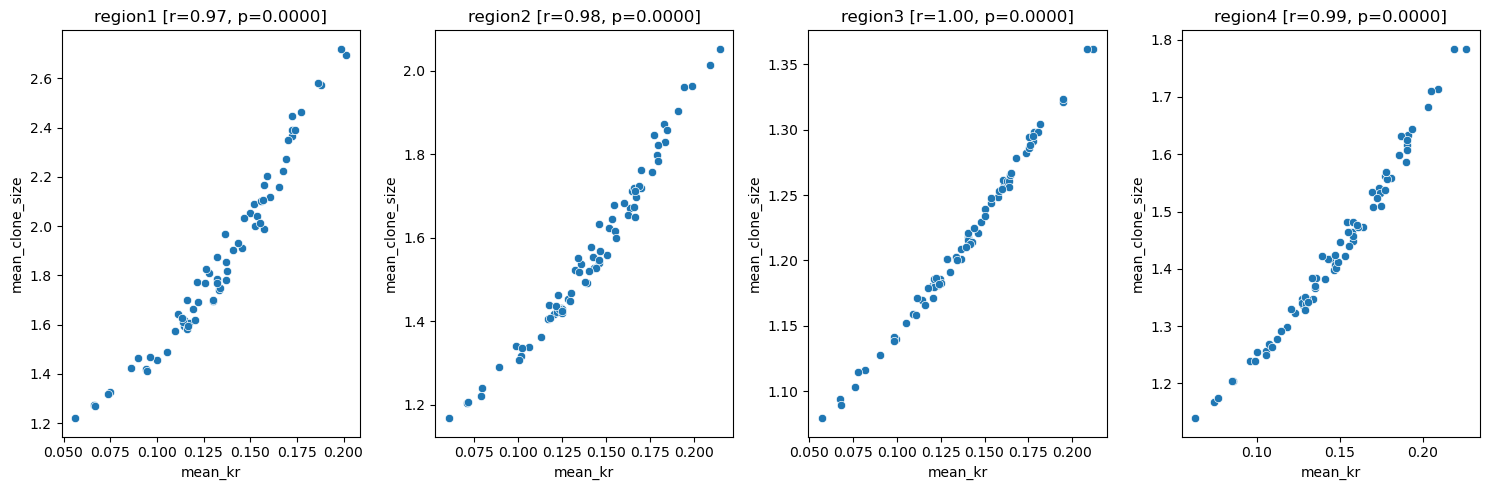

In [55]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_excel(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx",
        engine='openpyxl',
    )
patient_id = 'BrMET008'
patient_data = full_data[full_data['Patient']==patient_id]
region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
regions = [region for region in region_level_data.columns if 'region' in region]

fig, ax = plt.subplots(nrows=1, ncols=len(regions), figsize=(15, 5))
for i, region in enumerate(regions[:]):
    req_df = region_level_data[region_level_data[region]=='Yes']
    req_df = req_df.merge(patient_data, on='CDR3', how='inner')[list(req_df.columns)+['counts']]
    neoantigens = req_df['Peptide'].unique()
    num_of_neoantigens = len(neoantigens)
    patient_params_df = params_df[(params_df["Patient"] == patient_id) & (params_df["Region"] == region)]
    x1_value = patient_params_df["x1_panpep"].values[0]
    x2_value = patient_params_df["x2_panpep"].values[0]
    maxM = 1000
    mean_kr_and_clone_size_df = pd.DataFrame(columns=['peptide', 'mean_kr', 'mean_clone_size'])
    for j, antigen in tqdm.tqdm(enumerate(neoantigens[:]), desc=f'Processing {patient_id}-{region}:', total=num_of_neoantigens):
        neoantigen_data = req_df[req_df['Peptide']==antigen]
        probs_ = calc_probs_for_every_tcr(neoantigen_data['Score'].values*num_of_neoantigens/max_kr, x1_value, x2_value, maxM, disable_progressbar=True)
        size = 1000
        least_number_of_observations = 10
        configs_ = generate_configuration_per_tcr(probs_, size=size)
        mean_kr = np.mean(neoantigen_data['Score'].values*num_of_neoantigens/max_kr)
        mean_clone_size = np.mean(configs_.flatten())
        new_row = pd.Series({'peptide':antigen, 'mean_kr':mean_kr, 'mean_clone_size':mean_clone_size})
        mean_kr_and_clone_size_df = pd.concat([mean_kr_and_clone_size_df, new_row.to_frame().T], ignore_index=True)
    
    sns.scatterplot(data=mean_kr_and_clone_size_df, x='mean_kr', y='mean_clone_size', ax=ax[i])
    corr = pearsonr(mean_kr_and_clone_size_df['mean_kr'].astype(float), mean_kr_and_clone_size_df['mean_clone_size'].astype(float))
    ax[i].set_title(f'{region} [r={(corr.statistic):.2f}, p={(corr.pvalue):.4f}]')
plt.tight_layout()
plt.show()

In [55]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = full_data['kr'].max()
patients = np.unique(full_data['Patient'].values)
params_df = pd.read_excel(
        "/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx",
        engine='openpyxl',
    )
resulting_df = pd.DataFrame(columns=['patient', 'peptide', 'clonal', 'sub_clonal', 'private', 'mean_kr_panpep'])
for patient_id in tqdm.tqdm(patients[:], total=len(patients)):
    patient_data = full_data[full_data['Patient']==patient_id]
    region_level_data = pd.read_csv(f'{root_dir}/data/glioblastoma_data/PANPEP/{patient_id}/panpep_output_with_regions.csv', sep=',', comment='#')
    regions = [region for region in region_level_data.columns if 'region' in region]
    neoantigens = [region_level_data[region_level_data[region] == 'Yes']['Peptide'].unique() for region in regions]
    num_of_neoantigens_per_region = [len(neo_array) for neo_array in neoantigens]
    #add all unique neoantigens in the resulting_df
    unique_peptides = np.unique(np.concatenate(neoantigens))
    
    for peptide in tqdm.tqdm(unique_peptides, total=len(unique_peptides), desc=f'Processing {patient_id}: '):
        #find if peptide is clonal or sub-clonal or private from neoantigens list
        peptide_count = np.sum([peptide in neo_array for neo_array in neoantigens])
        is_it_clonal = peptide_count == len(regions)
        is_it_subclonal = 1 < peptide_count < len(regions)
        is_it_private = peptide_count == 1
        neoantigen_data = [(region_level_data[(region_level_data[region]=='Yes') & (region_level_data['Peptide']==peptide)])[['Peptide', 'Score']] for region in regions]
        # print(neoantigen_data)
        patient_params_df = [params_df[(params_df["Patient"] == patient_id) & (params_df["Region"] == region)] for region in regions]
        x2_value = [data['x2_panpep'].values[0] if not data.empty else np.nan for data in patient_params_df]
        # print(x2_value)
        mean_kr_times_x2_panpep = [(data['Score'].mean()*num_of_neoantigens_per_region[i]/max_kr)*x2_value[i] for i, data in enumerate(neoantigen_data) if not data.empty]
        new_row = pd.Series({'patient': patient_id, 'peptide': peptide, 'clonal': is_it_clonal, 'sub_clonal': is_it_subclonal, 'private': is_it_private, 'mean_kr_panpep': mean_kr_times_x2_panpep})
        resulting_df = pd.concat([resulting_df, new_row.to_frame().T], ignore_index=True)

Processing GBM079: 100%|██████████| 84/84 [00:04<00:00, 20.08it/s]


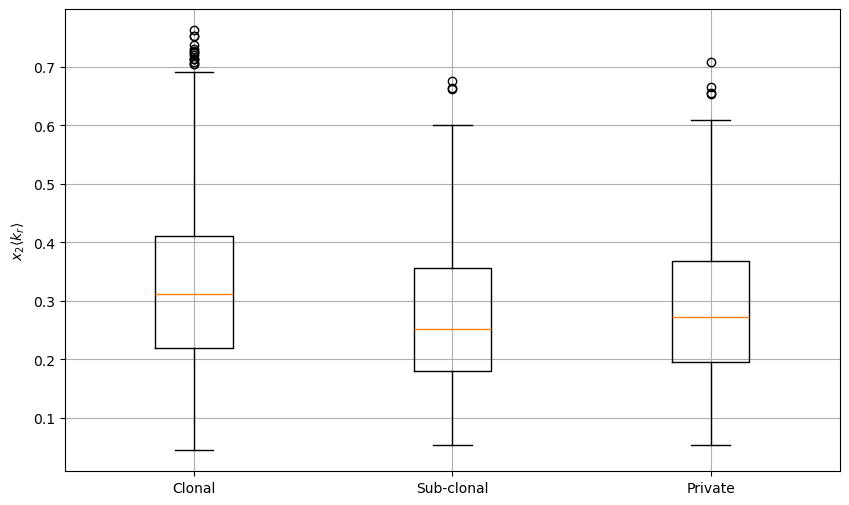

In [57]:
clonal_krs = np.concatenate(resulting_df[resulting_df['clonal']==True]['mean_kr_panpep'].values)
subclonal_krs = np.concatenate(resulting_df[resulting_df['sub_clonal']==True]['mean_kr_panpep'].values)
private_krs = np.concatenate(resulting_df[resulting_df['private']==True]['mean_kr_panpep'].values)

# Plotting
plt.figure(figsize=(10, 6))
data_to_plot = [clonal_krs, subclonal_krs, private_krs]
labels = ['Clonal', 'Sub-clonal', 'Private']
plt.boxplot(data_to_plot, tick_labels=labels, showfliers=True)
plt.ylabel(r'$x_2 \langle k_r \rangle$')
plt.grid(True)
plt.show()

In [130]:
from scipy.stats import ttest_ind
print(ttest_ind(clonal_krs, subclonal_krs, equal_var=False))
print(ttest_ind(clonal_krs, private_krs, equal_var=False))
print(ttest_ind(subclonal_krs, private_krs, equal_var=False))

TtestResult(statistic=np.float64(4.851357941531322), pvalue=np.float64(2.0605685002493795e-06), df=np.float64(273.81385874519094))
TtestResult(statistic=np.float64(5.040964760083799), pvalue=np.float64(6.085690893351739e-07), df=np.float64(620.6562770917295))
TtestResult(statistic=np.float64(-1.037264854936974), pvalue=np.float64(0.3001796139801549), df=np.float64(441.9565217330458))


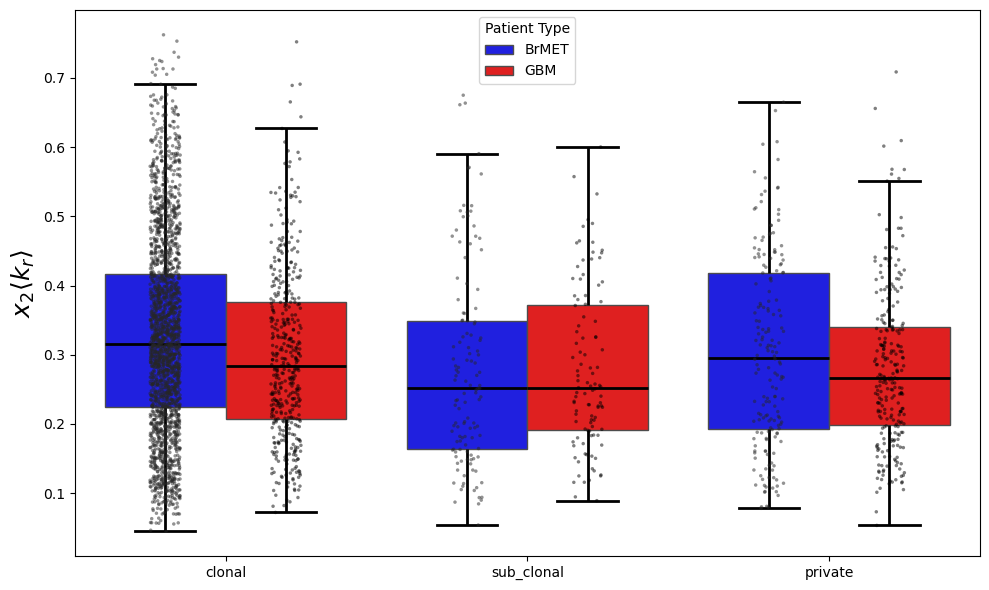

In [97]:
# Add a column to identify patient type
resulting_df['patient_type'] = resulting_df['patient'].apply(lambda x: 'BrMET' if 'BrMET' in x else 'GBM')

# Explode the mean_kr_panpep column to have one value per row
df_exploded = resulting_df.explode('mean_kr_panpep')

# Melt the DataFrame to long format for easier plotting
df_melted = df_exploded.melt(id_vars=['patient', 'peptide', 'patient_type', 'mean_kr_panpep'], 
                            value_vars=['clonal', 'sub_clonal', 'private'], 
                            var_name='category', value_name='value')

# Filter the DataFrame to include only rows where value is True
df_filtered = df_melted[df_melted['value']]

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='category', y='mean_kr_panpep', hue='patient_type', ax=ax, 
            showfliers=False,
            palette={'BrMET': 'blue', 'GBM': 'red'}, 
            medianprops={"color": "black", "linewidth": 2}, 
            whiskerprops={"color": "black", "linewidth": 2},
            capprops={"color": "black", "linewidth": 2})
sns.stripplot(data=df_filtered, x='category', y='mean_kr_panpep', hue='patient_type', 
            dodge=True, 
            alpha=0.5, 
            ax=ax, 
            marker='.', 
            size=5., 
            palette='dark:black')

# Adjust legend to avoid duplication
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], title='Patient Type')
ax.set_xlabel('', fontsize=18)
ax.set_ylabel(r'$x_2\langle k_r \rangle$', fontsize=18)
plt.tight_layout()
plt.show()

In [125]:
a = df_filtered[(df_filtered['patient_type']=='BrMET')&(df_filtered['category']=='clonal')]['mean_kr_panpep'].values
b = df_filtered[(df_filtered['patient_type']=='BrMET')&(df_filtered['category']=='sub_clonal')]['mean_kr_panpep'].values
c = df_filtered[(df_filtered['patient_type']=='BrMET')&(df_filtered['category']=='private')]['mean_kr_panpep'].values
d = df_filtered[(df_filtered['patient_type']=='GBM')&(df_filtered['category']=='clonal')]['mean_kr_panpep'].values
e = df_filtered[(df_filtered['patient_type']=='GBM')&(df_filtered['category']=='sub_clonal')]['mean_kr_panpep'].values
f = df_filtered[(df_filtered['patient_type']=='GBM')&(df_filtered['category']=='private')]['mean_kr_panpep'].values

In [127]:
print(f'(a, b): {ttest_ind(a.astype(float), b.astype(float), equal_var=False).pvalue}')
print(f'(a, c): {ttest_ind(a.astype(float), c.astype(float), equal_var=False).pvalue}')
print(f'(b, c): {ttest_ind(b.astype(float), c.astype(float), equal_var=False).pvalue}')
print(f'(d, e): {ttest_ind(d.astype(float), e.astype(float), equal_var=False).pvalue}')
print(f'(d, f): {ttest_ind(d.astype(float), f.astype(float), equal_var=False).pvalue}')
print(f'(e, f): {ttest_ind(e.astype(float), f.astype(float), equal_var=False).pvalue}')
print(f'(a, d): {ttest_ind(a.astype(float), d.astype(float), equal_var=False).pvalue}')
print(f'(c, f): {ttest_ind(c.astype(float), f.astype(float), equal_var=False).pvalue}')

(a, b): 0.0003331590391942484
(a, c): 0.0269724863721134
(b, c): 0.13950396107800417
(d, e): 0.11934439177571557
(d, f): 0.04898496385759755
(e, f): 0.8929348798352972
(a, d): 1.078769143064249e-05
(c, f): 0.06026355627463159
